In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from importlib import reload
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformerDropout import *
import os


In [2]:
torch.manual_seed(305)
device = 'cuda'

SMALL_ITERS = 1000
LARGE_ITERS = 2000
EVAL_ITERS = 100
CONTEXT_WINDOW_SIZE = 256


In [3]:
input_file_path = 'data/full_shakespeare.txt'

if not os.path.exists(input_file_path):
    data_url = 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 4,573,338


In [4]:
# Define a BPE model
vocab_size = 1700

tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
tokenizer.decoder = decoders.ByteLevel()

# Trainer with desired vocab size
trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["<unk>"])
# data should be an iterator over your text lines or documents
tokenizer.train_from_iterator([data], trainer=trainer)

# Encode and decode functions
def encode_bpe(text):
    return tokenizer.encode(text).ids

def decode_bpe(ids):
    return tokenizer.decode(ids)

# Example usage:
train_text = data[:int(len(data) * 0.9)]
val_text = data[int(len(data) * 0.9):]

train_tokens = encode_bpe(train_text)
val_tokens = encode_bpe(val_text)

train_data = torch.tensor(train_tokens)
val_data = torch.tensor(val_tokens)

print(f"train has {len(train_data):,} tokens")
print(f"val has {len(val_data):,} tokens")




train has 1,520,526 tokens
val has 168,070 tokens


In [5]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device, use_focal_loss=False, char_model = False):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses_by_type = {
            'ce_loss': torch.zeros(eval_iters),
        }
        if use_focal_loss:
            losses_by_type['f_loss'] = torch.zeros(eval_iters)

        for k in range(eval_iters):
            if char_model:
                X, Y = get_char_batch(split, context_window_size, device)
            else:
                X, Y = get_batch(split, context_window_size, device)
            logits, ce_loss, f_loss = model(X, Y)
            losses_by_type['ce_loss'][k] = ce_loss.item()
            if use_focal_loss:
                losses_by_type['f_loss'][k] = f_loss.item()

        out[split] = {'ce_loss': losses_by_type['ce_loss'].mean().item()}
        if use_focal_loss:
            out[split]['f_loss'] = losses_by_type['f_loss'].mean().item()

    return out

# Function for getting batches of character data
def get_char_batch(split, context_window_size, device, batch_size=32):
    """
    Generate a small batch of character-level data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: device to put tensors on
        batch_size: number of sequences in the batch
    """
    data = train_dataC if split == 'train' else val_dataC
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# Load DeepSeek as reference model with caching
def load_deepseek_reference():
    """
    Load DeepSeek reference model with caching to avoid redownloading
    """
    print("Loading DeepSeek reference model...")
    model_name = "deepseek-ai/deepseek-llm-7b-base"
    cache_dir = './deepseek_cache'

    # Create cache directory if it doesn't exist
    os.makedirs(cache_dir, exist_ok=True)

    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        cache_dir=cache_dir
    )
    model.eval()
    return model, tokenizer

def calculate_deepseek_log_prob(deepseek_model, deepseek_tokenizer, text):
    """
    Calculate the log probability of a text sequence under DeepSeek without length normalization
    """
    inputs = deepseek_tokenizer(text, return_tensors="pt").to(device)

    with torch.no_grad():
        # Get the target ids (shifted by 1 position)
        input_ids = inputs.input_ids
        target_ids = input_ids.clone()

        # Forward pass
        outputs = deepseek_model(input_ids, labels=target_ids)

        # Get the loss (negative log likelihood)
        neg_log_likelihood = outputs.loss.item()

        # Convert to log probability without normalization
        log_prob = -neg_log_likelihood

        return log_prob

def generate_text(model, prompt, encode_fn, decode_fn, max_tokens=100, temperature=1.0):
    """
    Generate text from a model using specific tokenization functions
    """
    model.eval()
    with torch.no_grad():
        # Convert prompt to tokens using model-specific tokenization
        token_ids = torch.tensor([encode_fn(prompt)], device=device)

        for _ in range(max_tokens):
            if token_ids.size(1) > CONTEXT_WINDOW_SIZE:
                token_ids = token_ids[:, -CONTEXT_WINDOW_SIZE:]

            # Get predictions
            logits, _, _ = model(token_ids)
            logits = logits[:, -1, :] / temperature

            # Sample from the distribution
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Append to the sequence
            token_ids = torch.cat([token_ids, next_token], dim=1)

        # Decode using model-specific decoding
        generated_text = decode_fn(token_ids[0].tolist())
        return generated_text, token_ids

# Compare two Shakespeare models using DeepSeek as reference
def compare_models_with_different_tokenization(
    model_a, model_b,
    encode_a_fn, decode_a_fn,
    encode_b_fn, decode_b_fn,
    deepseek_model, deepseek_tokenizer,
    prompts, max_tokens=100, num_samples=5):
    """
    Compare two models with different tokenization methods using DeepSeek
    """
    results = {
        'model_a': {
            'texts': [],
            'log_probs': [],
            'perplexities': []
        },
        'model_b': {
            'texts': [],
            'log_probs': [],
            'perplexities': []
        }
    }

    for prompt in tqdm(prompts, desc="Evaluating prompts"):
        for _ in range(num_samples):
            # Generate samples from both models using their specific tokenization
            text_a, _ = generate_text(model_a, prompt, encode_a_fn, decode_a_fn, max_tokens)
            text_b, _ = generate_text(model_b, prompt, encode_b_fn, decode_b_fn, max_tokens)

            # Calculate log probabilities under DeepSeek
            log_prob_a = calculate_deepseek_log_prob(deepseek_model, deepseek_tokenizer, text_a)
            log_prob_b = calculate_deepseek_log_prob(deepseek_model, deepseek_tokenizer, text_b)

            # Calculate perplexity (lower is better)
            perplexity_a = np.exp(-log_prob_a)
            perplexity_b = np.exp(-log_prob_b)

            # Store results
            results['model_a']['texts'].append(text_a)
            results['model_a']['log_probs'].append(log_prob_a)
            results['model_a']['perplexities'].append(perplexity_a)

            results['model_b']['texts'].append(text_b)
            results['model_b']['log_probs'].append(log_prob_b)
            results['model_b']['perplexities'].append(perplexity_b)

    # Calculate average metrics
    results['model_a']['avg_log_prob'] = np.mean(results['model_a']['log_probs'])
    results['model_a']['avg_perplexity'] = np.mean(results['model_a']['perplexities'])
    results['model_b']['avg_log_prob'] = np.mean(results['model_b']['log_probs'])
    results['model_b']['avg_perplexity'] = np.mean(results['model_b']['perplexities'])

    return results

# Visualize comparison results
def visualize_comparison(results, model_a_name="Model A", model_b_name="Model B"):
    """
    Visualize the comparison results between two models
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot log probabilities
    ax1.bar([model_a_name, model_b_name],
            [results['model_a']['avg_log_prob'], results['model_b']['avg_log_prob']])
    ax1.set_title('Average Log Probability (higher is better)')
    ax1.set_ylabel('Log Probability')

    # Plot perplexities
    ax2.bar([model_a_name, model_b_name],
            [results['model_a']['avg_perplexity'], results['model_b']['avg_perplexity']])
    ax2.set_title('Average Perplexity (lower is better)')
    ax2.set_ylabel('Perplexity')

    plt.tight_layout()
    plt.show()

# Print sample comparisons
def print_sample_comparisons(results, num_samples=3):
    """
    Print sample text generations from both models with their metrics
    """
    print(f"{'='*20} SAMPLE COMPARISONS {'='*20}")

    for i in range(min(num_samples, len(results['model_a']['texts']))):
        print(f"\nSample {i+1}:")

        # Model A
        text_a = results['model_a']['texts'][i]
        log_prob_a = results['model_a']['log_probs'][i]
        perplexity_a = results['model_a']['perplexities'][i]

        print(f"\nModel A (Log Prob: {log_prob_a:.4f}, Perplexity: {perplexity_a:.4f}):")
        print(text_a[:500] + "..." if len(text_a) > 500 else text_a)

        # Model B
        text_b = results['model_b']['texts'][i]
        log_prob_b = results['model_b']['log_probs'][i]
        perplexity_b = results['model_b']['perplexities'][i]

        print(f"\nModel B (Log Prob: {log_prob_b:.4f}, Perplexity: {perplexity_b:.4f}):")
        print(text_b[:500] + "..." if len(text_b) > 500 else text_b)

        print(f"\n{'='*50}")

# Main function to run the comparison
def run_model_comparison_different_tokenization(model_a, model_b,
                                               encode_a_fn, decode_a_fn,
                                               encode_b_fn, decode_b_fn,
                                               prompts):
    """
    Run the full comparison between two models with different tokenization
    """
    # Load DeepSeek reference model
    deepseek_model, deepseek_tokenizer = load_deepseek_reference()
    deepseek_model = deepseek_model.to(device)

    # Compare models
    results = compare_models_with_different_tokenization(
        model_a, model_b,
        encode_a_fn, decode_a_fn,
        encode_b_fn, decode_b_fn,
        deepseek_model, deepseek_tokenizer,
        prompts, max_tokens=100, num_samples=3
    )

    # Visualize results
    visualize_comparison(results, "BPE Tokenization", "Character Tokenization")

    # Print sample comparisons
    print_sample_comparisons(results, num_samples=2)

    return results

def train_model(model, optimizer, loss_fn="ce_loss", epochs=10, is_char_model=False):
    """
    Train a model for a specified number of epochs and track losses.

    Args:
        model: The model to train
        optimizer: The optimizer to use
        loss_fn: Which loss function to use ("ce_loss" or "focal_loss")
        epochs: Number of epochs to train for
        is_char_model: Whether this is a character model (uses different batch function)
    """
    model.train()

    # For tracking losses
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 100  # Number of batches per epoch

        for _ in tqdm(range(num_batches)):
            # Get batch using appropriate function
            if is_char_model:
                xb, yb = get_char_batch('train', CONTEXT_WINDOW_SIZE, device, batch_size=64)
            else:
                xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device, batch_size=64)

            # Forward pass
            logits, ce_loss, f_loss = model(xb, yb)

            # Use specified loss
            loss = ce_loss if loss_fn == "ce_loss" else f_loss

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()

            # Add gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()

        # Evaluate model after each epoch
        losses = estimate_loss(model, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device, use_focal_loss=(loss_fn=="focal_loss"), char_model=is_char_model)
        # losses = estimate_loss(model, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device, use_focal_loss=True,)


        # Store losses for plotting
        train_loss = losses['train']['ce_loss'] if loss_fn == "ce_loss" else losses['train']['f_loss']
        val_loss = losses['val']['ce_loss'] if loss_fn == "ce_loss" else losses['val']['f_loss']

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print progress
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Plot the training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss ({loss_fn})')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, val_losses



In [6]:
# Character-level tokenization
char_to_idx = {ch: i for i, ch in enumerate(sorted(set(''.join(data))))}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}

def encode_char(text):
    return [char_to_idx[c] if c in char_to_idx else char_to_idx.get('', 0) for c in text]

def decode_char(ids):
    return ''.join([idx_to_char.get(id, '') for id in ids])

# Create the train and test splits for character data
n = len(data)
train_chars = data[:int(n*0.9)]
val_chars = data[int(n*0.9):]

# Encode both to integers
train_dataC = torch.tensor(encode_char(train_chars))
val_dataC = torch.tensor(encode_char(val_chars))

print(f"Character train has {len(train_dataC):,} tokens")
print(f"Character val has {len(val_dataC):,} tokens")

Character train has 4,116,004 tokens
Character val has 457,334 tokens


In [7]:
# Create models with different tokenization methods
vocab_size = 2000

model_bpe = TransformerLM(vocab_size, CONTEXT_WINDOW_SIZE, dropout=0.1).to(device)
model_char = TransformerLM(len(char_to_idx), CONTEXT_WINDOW_SIZE, dropout=0.1).to(device)

In [10]:
# Train models with different loss functions
# For BPE model
# train_model(model_bpe, optim.Adam(model_bpe.parameters(), lr=1e-3), loss_fn="focal_loss", epochs=20)

# For character model (with lower learning rate and gradient clipping)
# train_model(model_char, optim.Adam(model_char.parameters(), lr=1e-4), loss_fn="focal_loss", epochs=20, is_char_model=True)

# # # Then load the saved parameters
model_bpe.load_state_dict(torch.load('model_bpe.pth'))
model_char.load_state_dict(torch.load('model_char.pth'))

# # # Set models to evaluation mode before inference
model_bpe.eval()
model_char.eval()

# Create prompts for evaluation
print("Loaded and/or trained models")

Loaded and/or trained models


In [25]:
prompts = [
    "To be, or not to be,",
    "Friends, Romans, countrymen,",
    "Now is the winter of our discontent"
]
# Classic examples

rand_batch = get_batch("val", CONTEXT_WINDOW_SIZE, device)[0]
for x in rand_batch:
    prompts.append(decode_bpe(x.tolist()))

Loading DeepSeek reference model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating prompts: 100%|██████████| 35/35 [02:43<00:00,  4.68s/it]


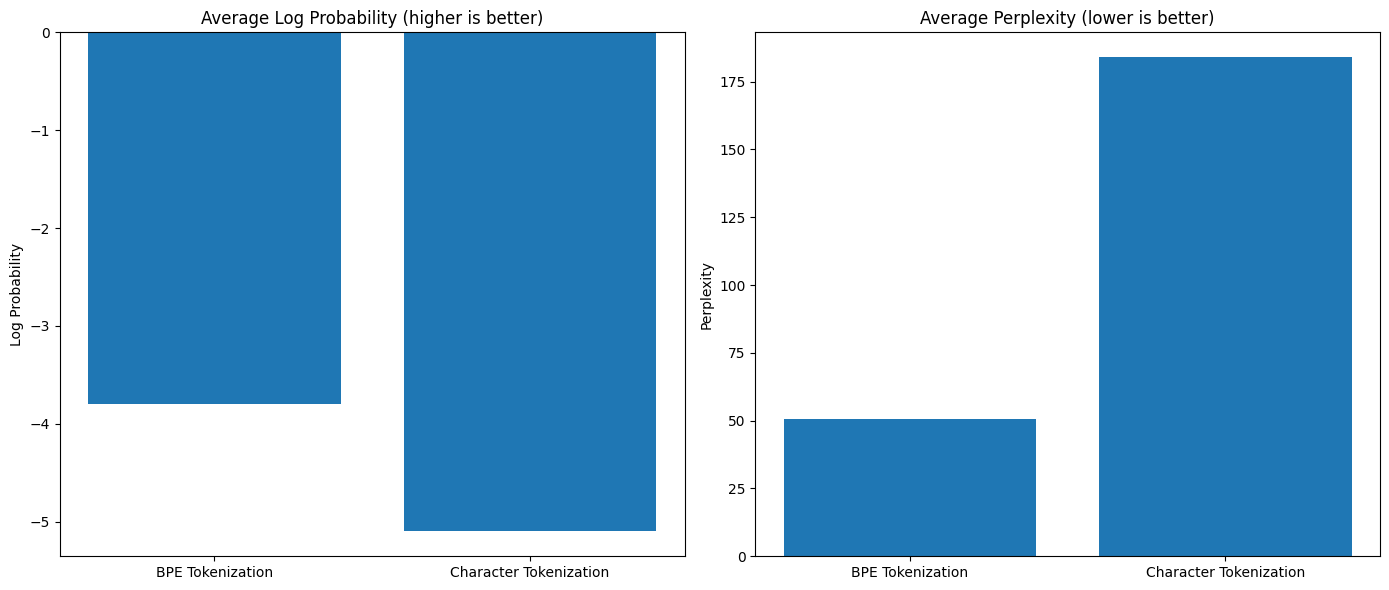

==================== SAMPLE COMPARISONS ====================

Sample 1:

Model A (Log Prob: -4.3878, Perplexity: 80.4663):
 To be, or not to be,
To any passion no further, nor the former.

KATHARINE:
By this I'll perceive it. Lord, good my liege,
Thanks, ladies:
Let us use me move, Kate, or make garment
To answer that 's me.' 'Doth I well
Have so selled that I told my guard?

GRUMIO:
About that I will to me

Model B (Log Prob: -5.4048, Perplexity: 222.4737):
To be, or not to be, what, if provaral'd
Is this may, some. God be know by speak me:
And greeling, that your fareward ne


Sample 2:

Model A (Log Prob: -2.9757, Perplexity: 19.6035):
 To be, or not to be, and you,
Cannot be abundance?

ISABELLA:
Was not my lord lost?

ANGELO:
Ay, sir:
To you, sir?

ANGELO:
I bade you, sir. And for your pardon.

ISABELLA:
For your conscience, my lord.

ANGELO:
I do beseech you now. The save your

Model B (Log Prob: -5.4338, Perplexity: 229.0247):
To be, or not to be,.

KING CLAUDIUS:
Go he not sent

In [27]:
# Run comparison
results = run_model_comparison_different_tokenization(
    model_bpe, model_char,
    encode_bpe, decode_bpe,
    encode_char, decode_char,
    prompts
)

In [15]:
# Save the final models
torch.save(model_bpe.state_dict(), 'model_bpe.pth')
torch.save(model_char.state_dict(), 'model_char.pth')